 # GAN para generación de  prendas y accesorios

 Usamos el dataset Fashion MNIST para entrenar una red neuronal generativa antagónica para  prendas y accesorios.


In [ ]:
#Importa las librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [ ]:

(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images, train_labels, test_images, test_labels

In [ ]:
#X_train=X_train.values
print(X_train.shape)

In [ ]:
#X_train=X_train.reshape(-1,28,28,1)
#print(X_train.shape)

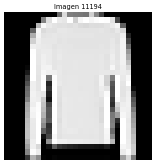

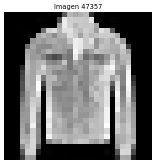

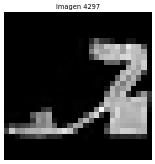

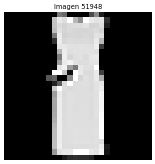

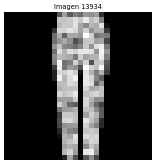

In [ ]:
# Carga y muestar algunas imágenes del dataset
sample_indices = random.sample(range(len(train_images)), 5) # Selecciona 5 índices aleatorios

for index in sample_indices:
  img = train_images[index] # Accede a la imagen utilizando el índice
  plt.figure(dpi=40)
  plt.imshow(img, cmap='gray') # Muestra la imagen en escala de grises
  plt.axis('off')
  plt.title(f"Imagen {index}")
  plt.show()

In [ ]:
# Carga y procesa el dataset CelebA

# Parámetros del dataset y del modelo
IMG_SIZE = (28, 28)
BATCH_SIZE = 64 # Probar más adelante 64, 128, o más
#NUMBER_OF_IMAGES = 2000 # Probar más adelante 2000, 10000, 20000... según la disponibilidad de GPU/TPU
NUM_CLASSES = 10

# Procesa las imaágenes del dataset
images = []
for image in test_images: # Subir a 2000, 10000, 20000... según la disponibilidad de GPU/TPU
  img = img_to_array(image)  / 127.5 - 1.0 # Normaliza entre -1 y 1
  images.append(img)

  # Convierte las imágenes a un array de numpy y prepeara el datset de TensorFlow
  dataset = np.array(images)
  dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)

print(f"Dataset procesado: {NUMBER_OF_IMAGES} imágenes cargadas y preparadas.")

Dataset procesado: 2000 imágenes cargadas y preparadas.


In [ ]:
# Verifica la estructura del dataset
for batch in dataset.take(1):
  print("Dimensiones del lote:", batch.shape)
  print("Rango: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (64, 28, 28, 1)
Rango: de -1.0 a 1.0


In [ ]:
# Define el generador
LATENT_DIM = 200

generator = keras.Sequential([
        # Capa de entrada para el ruido y la etiqueta de clase
    layers.InputLayer(input_shape=(LATENT_DIM + NUM_CLASSES,)),

    # Capa densa inicial
    layers.Dense(6 * 7 * 512, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensión a las dimensiones iniciales
    layers.Reshape((6, 7, 512)),

    # Primera capa de convolución
    layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Cuarta capa de convolución
    layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),


    # Capa final de ajuste a 28x28x1 (imagen en escala de grises)
    layers.Conv2D(1, (69, 85), activation="tanh")  # Cambio a 1 canal de salida y ajuste de tamaño de filtro


])

generator.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 21504)               │       4,322,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 21504)               │          86,016 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_74 (LeakyReLU)           │ (None, 21504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 6, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_59                  │ (None, 12, 14, 256)         │       3,276,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 12, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_75 (LeakyReLU)           │ (None, 12, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_60                  │ (None, 24, 28, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 24, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_76 (LeakyReLU)           │ (None, 24, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_61                  │ (None, 48, 56, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 48, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_77 (LeakyReLU)           │ (None, 48, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_62                  │ (None, 96, 112, 32)         │          51,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_78               │ (None, 96, 112, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_78 (LeakyReLU)           │ (None, 96, 112, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 1)           │         187,6

 Total params: 8,949,921 (34.14 MB)

 Trainable params: 8,905,953 (33.97 MB)

 Non-trainable params: 43,968 (171.75 KB)

In [ ]:
# Dimensiones de cada capa
noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(f"{layer.name}: {x.shape}")

dense_15: (1, 21504)
batch_normalization_74: (1, 21504)
leaky_re_lu_74: (1, 21504)
reshape_15: (1, 6, 7, 512)
conv2d_transpose_59: (1, 12, 14, 256)
batch_normalization_75: (1, 12, 14, 256)
leaky_re_lu_75: (1, 12, 14, 256)
conv2d_transpose_60: (1, 24, 28, 128)
batch_normalization_76: (1, 24, 28, 128)
leaky_re_lu_76: (1, 24, 28, 128)
conv2d_transpose_61: (1, 48, 56, 64)
batch_normalization_77: (1, 48, 56, 64)
leaky_re_lu_77: (1, 48, 56, 64)
conv2d_transpose_62: (1, 96, 112, 32)
batch_normalization_78: (1, 96, 112, 32)
leaky_re_lu_78: (1, 96, 112, 32)
conv2d_15: (1, 28, 28, 1)


In [ ]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 28, 28, 1)


Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: de -0.0077319923 a 0.013138329


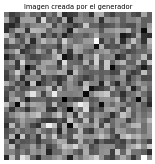

In [ ]:
# Comprueba que el generador está funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada

print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())
# muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="grey") # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis('off')
plt.title("Imagen creada por el generador")
plt.show()

In [ ]:
# Define el discriminador
discriminator = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 1 + NUM_CLASSES)),  # Imagen + etiqueta

    # Concatenar la imagen y la etiqueta
    layers.Reshape((28, 28, 1 + NUM_CLASSES)),

    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.1),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid") # Decide si la imagen es real o generada

])

In [ ]:
# Muestra el resumen del modelo
discriminator.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_83 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_84 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prueba el discriminador con la imagen cread por el generador

noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.5000201]]


Es normal que el discriminador indique incertidumbre por que todavía no hemos entrenado la GAN.

In [ ]:
# Inpecciona un lote del dataset
for batch in dataset.take(1):
  print("Dimensiones del lote:", batch.shape)
  break

Dimensiones del lote: (64, 28, 28, 1)


In [ ]:
# Parámetros del entrenamiento
EPOCHS = 100
# LATENT_DIM = 100
# BATCH_SIZE = 32

In [ ]:
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False) # No se necita logits poque la última capa era una sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

**Gradientes**: Son vectores que indican dirección y magnitud en la que aujstarse los pesos de un modelo para minimizar una función de pérdida.

In [ ]:
# # Entrenamiento de la GAN
# for epoch in range(EPOCHS):
#     print(f"Época {epoch + 1}/{EPOCHS}")

#     for real_images in dataset:
#         # Obtiene el tamaño del lote actual
#         current_batch_size = real_images.shape[0]

#         # Genera ruido aleatorio para crear imágenes falsas
#         noise = tf.random.normal([current_batch_size, LATENT_DIM])

#         # Crea imágenes falsas con el generador
#         generated_images = generator(noise, training=True)

#         # Etiquetas realies y falsas
#         real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
#         fake_labels = tf.zeros((current_batch_size, 1)) # Imágenes generadas (etiqueta = 0)

#         # Entrena el discriminador
#         with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
#             # Obtiene las predicciones del discriminador para las imágenes reales.
#             real_output = discriminator(real_images, training=True)
#             # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
#             fake_output = discriminator(generated_images, training=True)
#             # Calcula la pérdida del discriminador para las imágenes reales.
#             disc_loss_real = cross_entropy(real_labels, real_output)
#             # Calcula la pérdida del discriminador para las imágenes generadas (fake).
#             disc_loss_fake = cross_entropy(fake_labels, fake_output)
#             # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
#             disc_loss = disc_loss_real + disc_loss_fake

#         # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#         # Aplica los gradientes para actualizar los pesos del discriminador.
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#         # Genera ruido nuevamente para entrenar el generador
#         noise = tf.random.normal([current_batch_size, LATENT_DIM])

#         # Entrena el generador
#         with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
#             # Crea imágenes falsas con el generador
#             generated_images = generator(noise, training=True)
#             # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
#             fake_output = discriminator(generated_images, training=False)
#             # Calcula la pérdida del generador intentando "engañar" al discriminador.
#             gen_loss = cross_entropy(real_labels, fake_output)

#         # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         # Aplica los gradientes para actualizar los pesos del generador.
#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

#         # Muestra la pérdida de cada red neuronal
#         print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

#     # Guarda la GAN en ficheros
#     generator.save(f"generador_caras_{epoch + 1}ep_2000img.keras")
#     discriminator.save(f"discriminador_{epoch + 1}ep_2000img.keras")
#     # Muestra el progreso cada 2 épocas
#     #if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
#     if True:
#         # Genera y muestra imágenes de ejemplo
#         noise = tf.random.normal([16, LATENT_DIM])
#         generated_images = generator(noise, training=False)
#         generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]

#         fig, axes = plt.subplots(4, 4, figsize=(6, 6))
#         for img, ax in zip(generated_images, axes.flatten()):
#             ax.imshow(img)
#             ax.axis("off")
#         plt.show()

Época 1/100
Pérdida del discriminador: 1.392619013786316, Pérdida del generador: 0.724014163017273
Pérdida del discriminador: 1.5242135524749756, Pérdida del generador: 0.6102299690246582
Pérdida del discriminador: 1.5341157913208008, Pérdida del generador: 0.5552671551704407
Pérdida del discriminador: 1.6250979900360107, Pérdida del generador: 0.5071767568588257
Pérdida del discriminador: 1.6137999296188354, Pérdida del generador: 0.5054274797439575
Pérdida del discriminador: 1.6254128217697144, Pérdida del generador: 0.48454028367996216
Pérdida del discriminador: 1.5942429304122925, Pérdida del generador: 0.4911723732948303
Pérdida del discriminador: 1.585682988166809, Pérdida del generador: 0.49996405839920044
Pérdida del discriminador: 1.5445594787597656, Pérdida del generador: 0.5209252834320068
Pérdida del discriminador: 1.4944796562194824, Pérdida del generador: 0.5481816530227661
Pérdida del discriminador: 1.4622135162353516, Pérdida del generador: 0.5726286172866821
Pérdida de

In [ ]:
# Entrenamiento del cGAN
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    for real_images, labels in dataset:
        current_batch_size = real_images.shape[0]

        # Genera ruido aleatorio para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])
        # Concatenar ruido y etiqueta
        label_one_hot = tf.one_hot(labels, NUM_CLASSES)
        gen_input = tf.concat([noise, label_one_hot], axis=1)

        # Crea imágenes falsas con el generador
        generated_images = generator(gen_input, training=True)

        # Etiquetas reales y falsas
        real_labels = tf.ones((current_batch_size, 1))  # Imágenes reales (etiqueta = 1)
        fake_labels = tf.zeros((current_batch_size, 1))  # Imágenes generadas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape:
            # Concatenar imagen real con etiqueta
            real_input = tf.concat([real_images, tf.one_hot(labels, NUM_CLASSES)], axis=-1)
            real_output = discriminator(real_input, training=True)

            # Concatenar imagen generada con etiqueta
            fake_input = tf.concat([generated_images, label_one_hot], axis=-1)
            fake_output = discriminator(fake_input, training=True)

            # Calcula la pérdida del discriminador
            disc_loss_real = cross_entropy(real_labels, real_output)
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            disc_loss = disc_loss_real + disc_loss_fake

        # Actualiza los pesos del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Entrenamiento del generador
        with tf.GradientTape() as gen_tape:
            fake_output = discriminator(fake_input, training=False)
            gen_loss = cross_entropy(real_labels, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Mostrar progreso
        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Muestra las imágenes generadas cada 2 épocas
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        noise = tf.random.normal([16, LATENT_DIM])
        labels = tf.random.uniform([16], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
        label_one_hot = tf.one_hot(labels, NUM_CLASSES)
        gen_input = tf.concat([noise, label_one_hot], axis=1)
        generated_images = generator(gen_input, training=False)
        generated_images = (generated_images + 1) / 2  # Reescala de [-1, 1] a [0, 1]

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img.numpy().reshape(28, 28), cmap='gray')
            ax.axis("off")
        plt.show()


In [ ]:
# Graba en disco los modelos.
generator.save("generador_caras_100ep_2000img.keras")
discriminator.save("discriminador_100ep_2000img.keras")

In [ ]:
# Carga los modelos en memoria. Mover bloque donde proceda (por ej. justo antes del entrenamiento)
generator = load.save("generador_caras_100ep_2000img.keras")
discriminator = load.save("discriminador_100ep_2000img.keras")

In [ ]:
# Prueba el generador cargado
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Muestra la imagen generada por el generador

print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())